In [46]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import pearsonr
import pingouin as pg
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")


# Functions

In [47]:
# ------------------------------------------------------------------------------------------------------------
# Cleaning functions
# ------------------------------------------------------------------------------------------------------------
def get_max_payoff(f1, f2, cost1=0, cost2=0):
    data = np.zeros((11-cost2, 11-cost1))
    for i in range(11-cost1):
        for j in range(11-cost2):
            data[j, i] = 10 - i - cost1 + ((i*f1 + j*f2)/2)
    return np.amax(data)


def add_max_payoff(df, cost=None, with_group=True):
    if with_group:
        group_ids = df['group_id'].unique()
    f1, f2 = sorted(df['multiplier'].unique())
    df['max_payoff'] = np.NaN
    matching = {}
    for m1, m2 in ((f1, f2), (f1, f1), (f2, f1), (f2, f2)):
        matching[(m1, m2)] = [get_max_payoff(m1, m2), get_max_payoff(m2, m1)]

    if not with_group:
        for i, d in df.iterrows():
            t1 = d['multiplier']
            t2 = d['opp_multiplier']
            c1 = int(d['disclose'])
            c2 = int(d['opp_disclose'])

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[i, 'max_payoff'] = max_payoff[0]
            df.loc[i, 'opp_max_payoff'] = max_payoff[1]
        return df 


    for g in group_ids:
        d = df[df['group_id'] == g]
        if len(d) == 2:
            idx = d.index.tolist()
            t1 = d.iloc[0]['multiplier']
            t2 = d.iloc[1]['multiplier']
            c1 = d.iloc[0]['disclose']
            c2 = d.iloc[1]['disclose']

            max_payoff = matching[t1, t2]

            if cost:
                max_payoff = [get_max_payoff(t1, t2, cost1=cost*c1, cost2=c2*cost),
                              get_max_payoff(t2, t1, cost1=cost*c2, cost2=c1*cost)]

            df.loc[idx[0], 'max_payoff'] = max_payoff[0]
            df.loc[idx[1], 'max_payoff'] = max_payoff[1]
    return df


def add_norm_payoff(df, with_opp):
    df['norm_payoff'] = df['payoff']/df['max_payoff']
    if with_opp:
        df['opp_norm_payoff'] = df['opp_payoff']/df['opp_max_payoff']
    return df


def remove_bots(df):
    prolific_id_to_exclude = df[df['rt1'] == -1]['prolific_id'].unique()
    df = df[~df['prolific_id'].isin(prolific_id_to_exclude)]
    return df


def add_subjects(df, num):
    df['id_in_session'] = df['id_in_session'] + (num*100)
    return df


def remove_bots_but_keep_previous_rows(df):
    return df[df['rt1'] != -1]


def remove_trials_where_both_players_are_bots(df):
    group_ids = df['group_id'].unique()
    for g in group_ids:
        d = df[df['group_id'] == g]
        idx = d.index.tolist()
        rt1 = d.iloc[0]['rt1'] == -1
        rt2 = d.iloc[1]['rt1'] == -1
        if rt1 and rt2:
            df = df.drop(idx)
    return df


def remove_incomplete_sub(df, n):
    count = 0
    for i in df['prolific_id'].unique():
        count += len(df[df['prolific_id'] == i]) == n
    # exclude prolific ids with incomplete data (!= n)
    df = df[df.prolific_id.isin(
        df.prolific_id.value_counts()[df.prolific_id.value_counts() == n].index)]
    return df, count


# Data clearning

In [48]:
exp = [
    'data/' + f for f in
    ['theresa_sorting.csv',
     'theresa_control.csv',
     'theresa_with_cost.csv',
     'theresa_single.csv',
     'cost_single_final_58.csv',
     ]
]

dfs = [pd.read_csv(f) for f in exp]

for i, d in enumerate(dfs):
   dfs[i] = remove_bots(dfs[i].copy())
   dfs[i], count = remove_incomplete_sub(
        df=dfs[i].copy(), n=63 if i in [3, 4] else 60)
   dfs[i] = add_max_payoff(df=dfs[i].copy(), cost=2 if i in [2, 4] else None, with_group=not i in [3,4])
   dfs[i] = add_norm_payoff(df=dfs[i].copy(), with_opp= i in [3, 4])
   print(f'Exp {i}', f'N={count}', f'filename={exp[i]}')

# df = pd.read_csv('data/cost_single_final_58.csv')
    # df['prolific_id']
df = dfs[4].copy()
(df.rt1.unique()==-1).sum()
dd = df.groupby('prolific_id').multiplier.value_counts()

#

Exp 0 N=30 filename=data/theresa_sorting.csv
Exp 1 N=22 filename=data/theresa_control.csv
Exp 2 N=23 filename=data/theresa_with_cost.csv
Exp 3 N=56 filename=data/theresa_single.csv
Exp 4 N=46 filename=data/cost_single_final_58.csv


0

# Check sanity of the data

1.5    25
2.5    21
Name: multiplier, dtype: int64

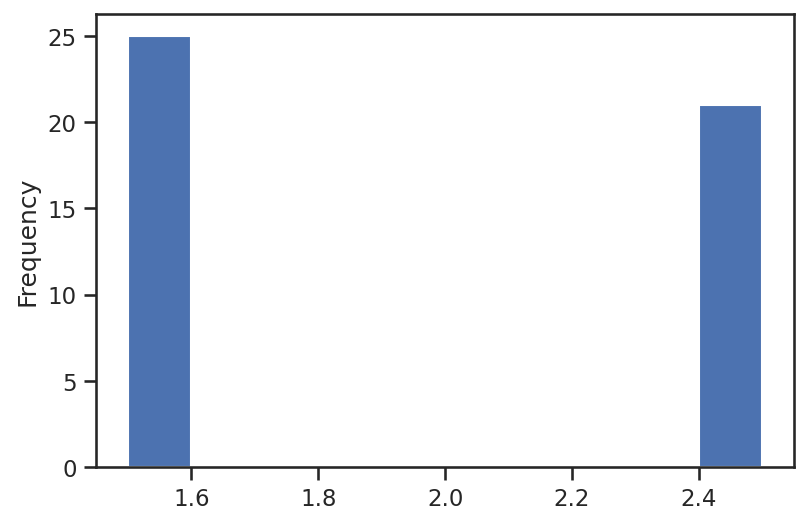

2.0    46
Name: opp_multiplier, dtype: int64

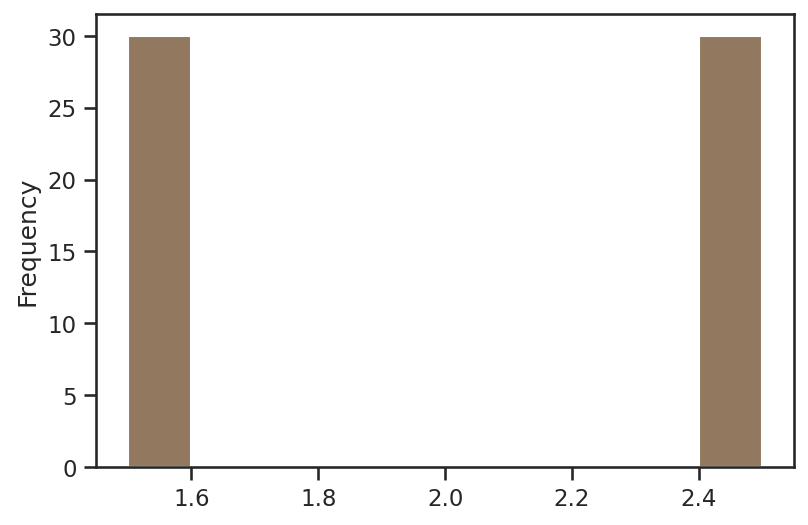

<AxesSubplot:xlabel='round_number', ylabel='opp_multiplier'>

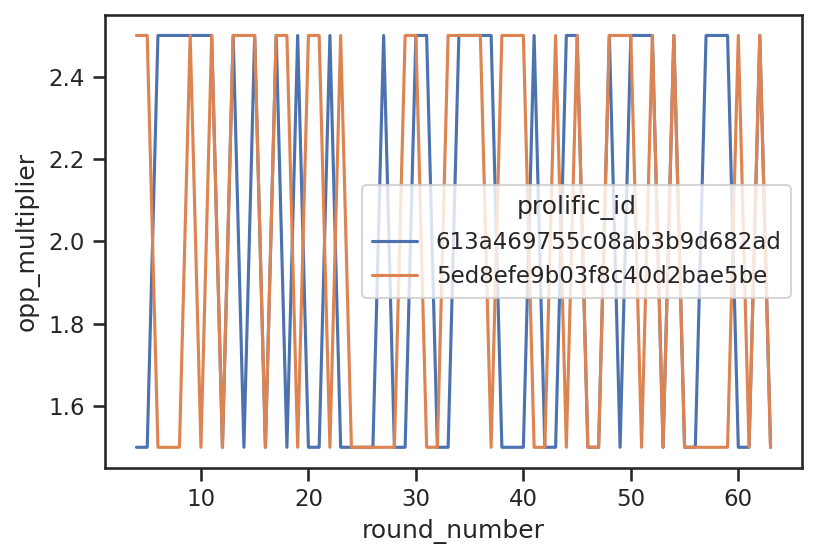

<AxesSubplot:xlabel='round_number', ylabel='opp_p_disclose'>

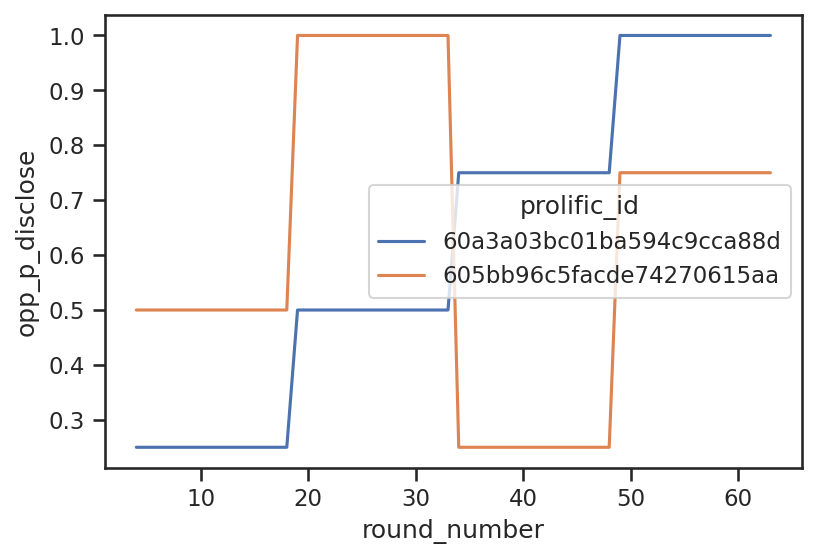

<AxesSubplot:xlabel='round_number', ylabel='opp_contribution'>

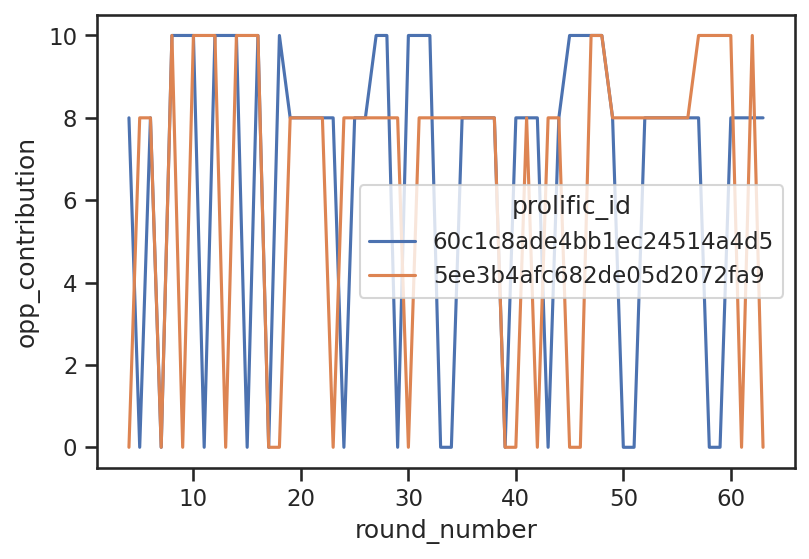

In [49]:

df = dfs[4].copy()
df = df[df.round_number>3]

# we manipulate the player multiplier (50/50)
fig1 = df.groupby('prolific_id').mean().multiplier.plot(kind='hist')
df.groupby('prolific_id', as_index=True).mean().multiplier.value_counts()
plt.show()

# we manipulate the opposant multiplier (50/50), also it is randomized across trials
fig2 = df.groupby('prolific_id').opp_multiplier.plot(kind='hist')
df.groupby('prolific_id').mean().opp_multiplier.value_counts()
plt.show()
sns.lineplot(x='round_number', y='opp_multiplier', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
plt.show()

# we manipulate the opp p disclose
sns.lineplot(x='round_number', y='opp_p_disclose', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
plt.show()

# we manipulate the opp contribution decision
sns.lineplot(x='round_number', y='opp_contribution', hue='prolific_id', data=df[df.prolific_id.isin(df.prolific_id.sample(2))])
# plot(x='round_number', y='opp_multiplier', legend=True)
# sns.lineplot(x='round_number', y='disclose', hue='multiplier', data=df,ci=68)

# Variables Corr

               multiplier opp_p_disclose opp_multiplier disclose contribution  \
multiplier            0.0            1.0            1.0      0.0          0.0   
opp_p_disclose        1.0            0.0            1.0   0.9275       0.2462   
opp_multiplier        1.0            1.0            0.0   0.8897       0.0006   
disclose              0.0         0.9275         0.8897      0.0       0.5451   
contribution          0.0         0.2462         0.0006   0.5451          0.0   
norm_payoff        0.1083         0.4963            0.0   0.6881       0.0906   

               norm_payoff  
multiplier          0.1083  
opp_p_disclose      0.4963  
opp_multiplier         0.0  
disclose            0.6881  
contribution        0.0906  
norm_payoff            0.0  


<AxesSubplot:>

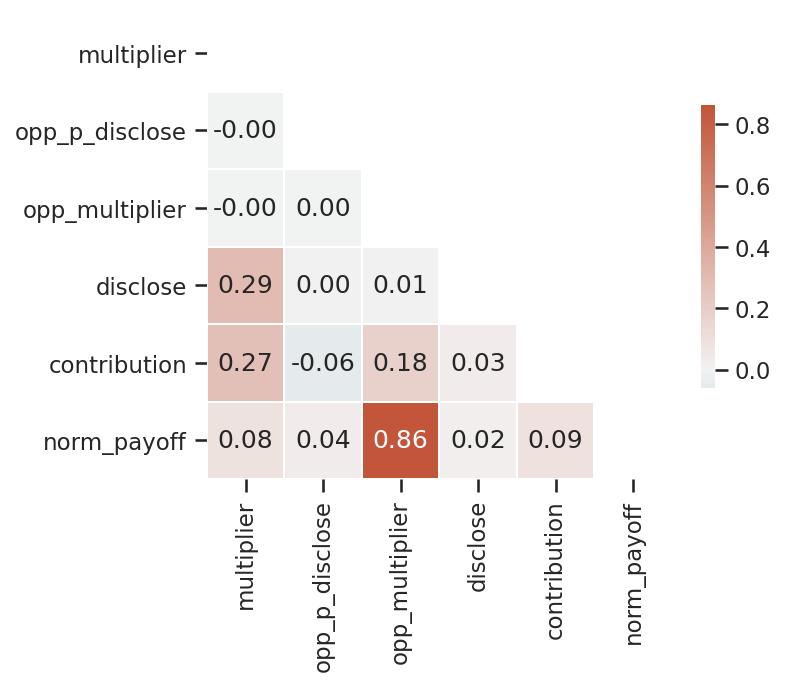

In [50]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues



selected_exp = 4
df = dfs[selected_exp].copy()
# df = df[df['round_number'] < 30]

x = df.groupby(
    ['prolific_id','multiplier','opp_p_disclose', 'opp_multiplier'], as_index=False
    )[['disclose', 'contribution', 'norm_payoff']].mean()

# y = df.groupby(['prolific_id', 'multiplier' ], as_index=False)['contribution'].mean()

# Compute the correlation matrix
corr = x.corr()
p = calculate_pvalues(x)

print(p)

# combining text with values
# formatted_text = (np.asarray(["{0}\n{1:.2f}".format(
    # text, data) for text, data in zip(p.flatten(), corr.flatten())])).reshape(3, 5)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,  center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=corr, fmt=".2f")

#
#

# Variables Regressions

In [51]:
selected_exp = 4
df = dfs[selected_exp].copy()

x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'contribution', 'norm_payoff', 'payoff']].mean()
pg.pairwise_corr(data=x, padjust='bonf')

,X,Y,method,alternative,n,r,CI95%,p-unc,p-corr,p-adjust,BF10,power
0,multiplier,disclose,pearson,two-sided,46,0.378770,"[0.1, 0.6]",9.438387e-03,9.438387e-02,bonf,4.815,0.751323
1,multiplier,contribution,pearson,two-sided,46,0.322471,"[0.04, 0.56]",2.883954e-02,2.883954e-01,bonf,1.862,0.600047
2,multiplier,norm_payoff,pearson,two-sided,46,0.379670,"[0.1, 0.6]",9.256591e-03,9.256591e-02,bonf,4.897,0.753523
3,multiplier,payoff,pearson,two-sided,46,0.835476,"[0.72, 0.91]",5.144365e-13,5.144365e-12,bonf,1.64e+10,1.000000
4,disclose,contribution,pearson,two-sided,46,0.046171,"[-0.25, 0.33]",7.606025e-01,1.000000e+00,bonf,0.192,0.060433
5,disclose,norm_payoff,pearson,two-sided,46,0.044707,"[-0.25, 0.33]",7.679757e-01,1.000000e+00,bonf,0.192,0.059756
6,disclose,payoff,pearson,two-sided,46,-0.020569,"[-0.31, 0.27]",8.920746e-01,1.000000e+00,bonf,0.185,0.051784
7,contribution,norm_payoff,pearson,two-sided,46,-0.180707,"[-0.45, 0.12]",2.294387e-01,1.000000e+00,bonf,0.37,0.226899
8,contribution,payoff,pearson,two-sided,46,0.173346,"[-0.12, 0.44]",2.492887e-01,1.000000e+00,bonf,0.35,0.212180
9,norm_payoff,payoff,pearson,two-sided,46,0.729506,"[0.56, 0.84]",8.882137e-09,8.882137e-08,bonf,1.642e+06,0.999985


In [52]:
selected_exp = 4
df = dfs[selected_exp].copy()



<Figure size 1200x900 with 0 Axes>

(-0.1, 1.1)

<Figure size 1200x900 with 0 Axes>

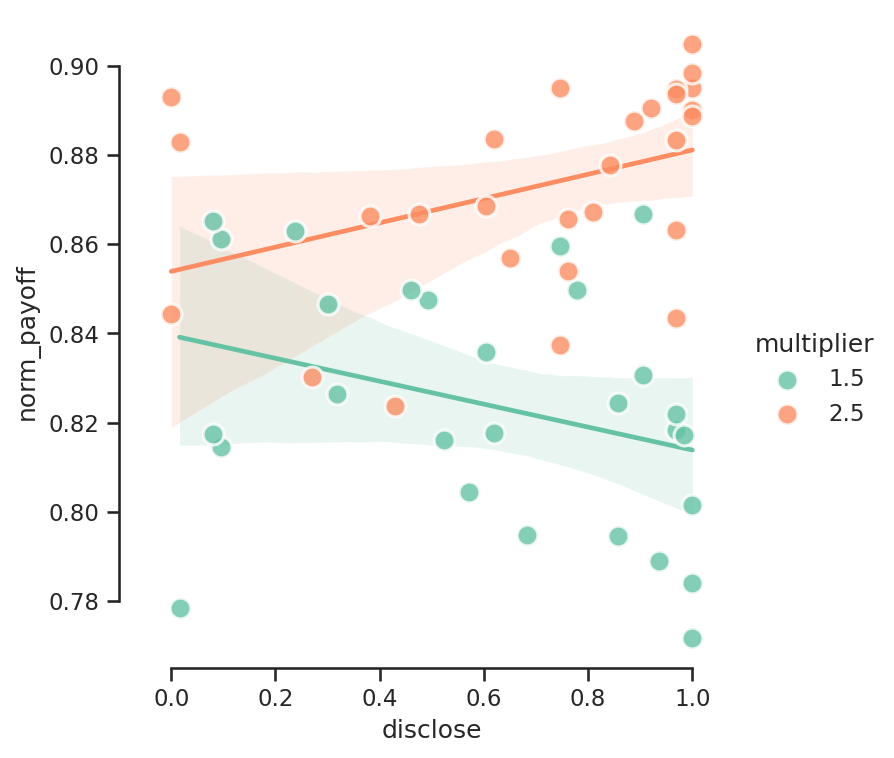

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           contribution   R-squared:                       0.237
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     8.252
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           0.000759
Time:                        17:08:20   Log-Likelihood:                -121.18
No. Observations:                  56   AIC:                             248.4
Df Residuals:                      53   BIC:                             254.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7061      1.263      1.351      0.182      -0.827       4.239
disclose       2.3636      0.889      2.659      0.010       0.581       4.147
multiplier     1.5508      0.585      2.652      0.011       0.378       2.724
==============================================================================
Omnibus:                        0.584   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.747   Jarque-Bera (JB):                0.697
Skew:                           0.212   Prob(JB):                        0.706
Kurtosis:                       2.655   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            norm_payoff   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     26.24
Date:                Tue, 21 Feb 2023   Prob (F-statistic):           1.20e-08
Time:                        17:08:20   Log-Likelihood:                 127.72
No. Observations:                  56   AIC:                            -249.4
Df Residuals:                      53   BIC:                            -243.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7503      0.015     50.598      0.000       0.721       0.780
disclose      -0.0006      0.010     -0.057      0.955      -0.022       0.020
multiplier     0.0493      0.007      7.175      0.000       0.036       0.063
==============================================================================
Omnibus:                        3.290   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.193   Jarque-Bera (JB):                2.166
Skew:                          -0.281   Prob(JB):                        0.339
Kurtosis:                       2.217   Cond. No.                         11.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
selected_exp = 3
df = dfs[selected_exp].copy()
# df = df[df['round_number'] > 30]
vd = 'norm_payoff'
x = df.groupby(['prolific_id', 'multiplier'], as_index=False)[['disclose', 'contribution', 'norm_payoff', 'payoff']].mean()

# x = x[x['multiplier']==1.5]
# y = df.groupby(['prolific_id', 'multiplier' ], as_index=False)['contribution'].mean()
# x = x[x['disclose'] <= .5]
model1 = smf.ols(formula='contribution ~ disclose + multiplier', data=x).fit()
model2 = smf.ols(formula='norm_payoff ~ disclose + multiplier', data=x).fit()


# fig, axs = plt.subplots(1, 2)
sns.set_palette('Set2')
# sns.regplot(ax=axs[0],
   # x='disclose',
   # y='contribution',  data=x, scatter_kws={'clip_on': False, 'zorder': 10, 'edgecolor': 'white', 'lw': 1.5, 's': 100})
# plt.ylabel('Contribution rate')
plt.figure(figsize=(8, 6))
sns.lmplot(
   x='disclose',
   y=vd, hue="multiplier", data=x, scatter_kws={'clip_on': False, 'zorder': 10, 'edgecolor': 'white', 'lw': 1.5, 's': 100})
# plt.ylim(.7,1)
plt.xlim(-0.1,1.1)
# remove left spines and set smart bounds
sns.despine(right=True, top=True, trim=True)
# plt.gca().spines['bottom'].set_smart_bounds(True)
plt.show()

model1.summary()
model2.summary()

# Logistic fit

Optimization terminated successfully.
         Current function value: 0.492738
         Iterations 6


/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['skip_hessian']
  warnings.warn(msg, ValueWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['skip_hessian']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               disclose   No. Observations:                 2898
Model:                          Logit   Df Residuals:                     2894
Method:                           MLE   Df Model:                            3
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                 0.04419
Time:                        17:08:20   Log-Likelihood:                -1428.0
converged:                       True   LL-Null:                       -1494.0
Covariance Type:            nonrobust   LLR p-value:                 1.982e-28
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.8299      0.111    -16.524      0.000      -2.047      -1.613
C(multiplier)[T.2.5]                  1.3865      0.163      8.481      0.000       1.066       1.707
contribution                         -0.0043      0.018     -0.241      0.810      -0.040       0.031
contribution:C(multiplier)[T.2.5]    -0.0604      0.025     -2.419      0.016      -0.109      -0.011
=====================================================================================================
"""

<Figure size 1200x900 with 0 Axes>

(-1.0, 11.0)

<Figure size 1200x900 with 0 Axes>

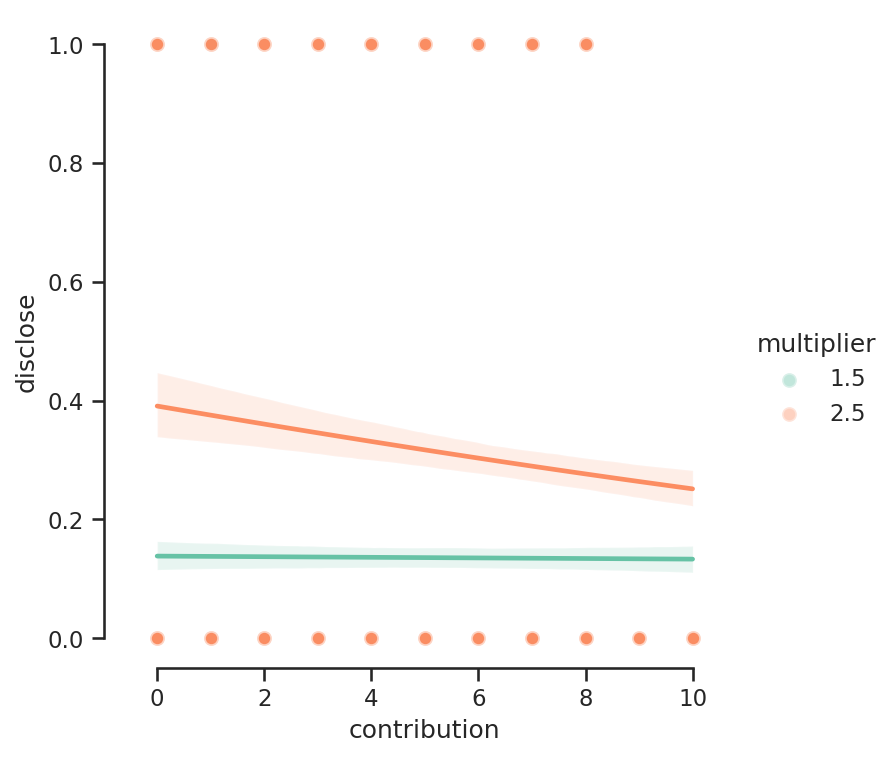

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               disclose   No. Observations:                 2898
Model:                          Logit   Df Residuals:                     2894
Method:                           MLE   Df Model:                            3
Date:                Tue, 21 Feb 2023   Pseudo R-squ.:                 0.04419
Time:                        17:08:25   Log-Likelihood:                -1428.0
converged:                       True   LL-Null:                       -1494.0
Covariance Type:            nonrobust   LLR p-value:                 1.982e-28
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -1.8299      0.111    -16.524      0.000      -2.047      -1.613
C(multiplier)[T.2.5]                  1.3865      0.163      8.481      0.000       1.066       1.707
contribution                         -0.0043      0.018     -0.241      0.810      -0.040       0.031
contribution:C(multiplier)[T.2.5]    -0.0604      0.025     -2.419      0.016      -0.109      -0.011
=====================================================================================================
"""

In [54]:
selected_exp = 4
df = dfs[selected_exp].copy()
vd = 'disclose'

model1 = smf.logit(formula='disclose ~ contribution * C(multiplier)', data=df, skip_hessian=True).fit()
# model2 = smf.ols(formula='norm_payoff ~ disclose + multiplier', data=x).fit()
model1.summary()

# fig, axs = plt.subplots(1, 2)
sns.set_palette('Set2')
plt.figure(figsize=(8, 6))
sns.lmplot(
   x='contribution',
   y=vd, hue='multiplier', data=df, 
   logistic=True,
   scatter_kws=dict(clip_on=False, zorder=10, alpha=.4, edgecolor='white', lw=1.5, s=50))
# plt.ylim(.7,1)
plt.xlim(-1,11)
# remove left spines and set smart bounds
sns.despine(right=True, top=True, trim=True)
# plt.gca().spines['bottom'].set_smart_bounds(True)
plt.show()

model1.summary()

<AxesSubplot:xlabel='multiplier', ylabel='contribution'>

<AxesSubplot:xlabel='multiplier', ylabel='contribution'>

<AxesSubplot:xlabel='multiplier', ylabel='contribution'>

Text(0, 0.5, 'average contribution')

               T        dof alternative    p-val           CI95%   cohen-d  \
T-test -2.306626  43.861169   two-sided  0.02586  [-3.15, -0.21]  0.668897   

         BF10    power  
T-test  2.374  0.59883  


/tmp/ipykernel_40897/2422717638.py:49: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['left'].set_smart_bounds(True)
/tmp/ipykernel_40897/2422717638.py:50: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['bottom'].set_smart_bounds(True)


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,multiplier,136.887414,1,44,136.887414,5.338903,0.025603,0.108209,NaN
1,opp_p_disclose,20.990115,3,132,6.996705,2.936470,0.035752,0.062563,0.901057
2,Interaction,17.354988,3,132,5.784996,2.427924,0.068274,0.052294,NaN


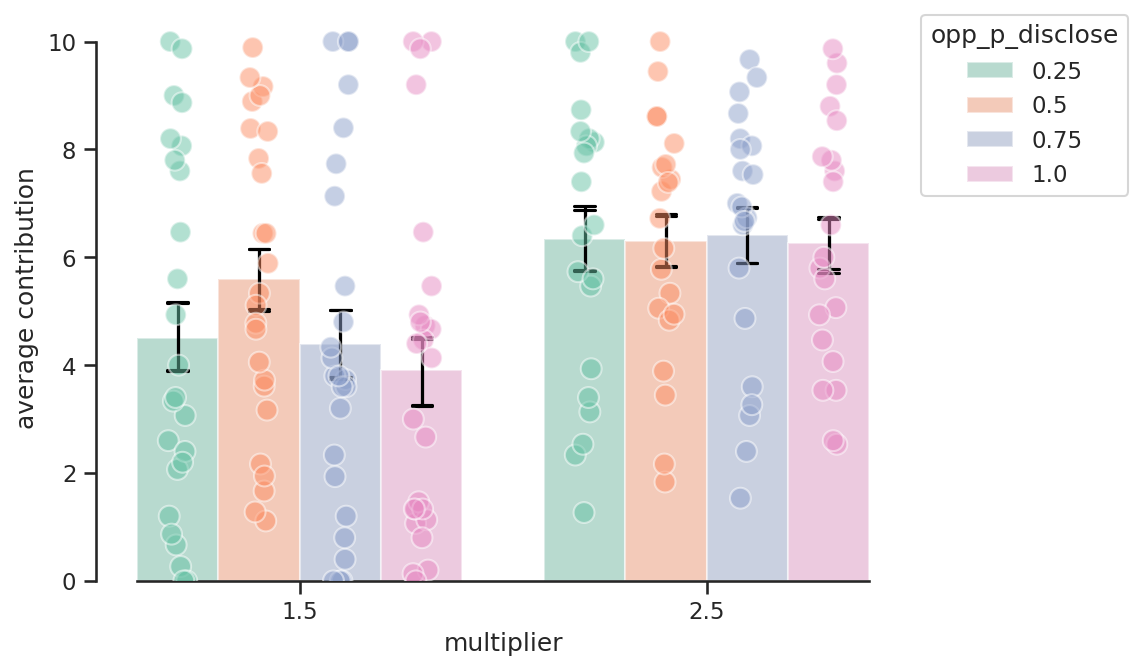

In [55]:
selected_exp = 4
df = dfs[selected_exp]

vi = 'opp_p_disclose'
vd = 'contribution'

fig, ax = plt.subplots(figsize=(7, 5))

df2 = df.groupby(['prolific_id', 'multiplier',
                    vi], as_index=False)[vd].mean()

sns.set_palette("Set2")

sns.barplot(
    x='multiplier',
    y=vd,
    hue=vi, data=df2, ci=68,
    edgecolor="white",
    errcolor="black",
    errwidth=1.5,
    capsize=0.05, 
    alpha=0.5, ax=ax, zorder=1)

# sns.pointplot()
sns.stripplot(
    x='multiplier',
     y=vd, hue=vi, data=df2, dodge=True,
              jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1, zorder=5)

sns.barplot(
   x='multiplier',
   y=vd,
   hue=vi, data=df2, ci=68,
   edgecolor="white",
   errcolor="black",
   errwidth=1.5,
   capsize=0.05,
   alpha=0., zorder=10)
#


handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[8:], title=vi,
          bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True)

plt.ylabel(f'average {vd}')

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)

df3 = df.groupby(['prolific_id', 'multiplier'], as_index=False)[vd].mean()

r = pg.ttest(x=df3[df3['multiplier'] == 1.5][vd],
         y=df3[df3['multiplier'] == 2.5][vd])
# plt.ylim(.6, 1)
print(r)
pg.mixed_anova(data=df2, dv=vd, between="multiplier", within=vi, subject='prolific_id')


<AxesSubplot:xlabel='multiplier', ylabel='disclose'>

<AxesSubplot:xlabel='multiplier', ylabel='disclose'>

Text(0, 0.5, 'average disclosure')

/tmp/ipykernel_40897/402063251.py:21: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['left'].set_smart_bounds(True)
/tmp/ipykernel_40897/402063251.py:22: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  plt.gca().spines['bottom'].set_smart_bounds(True)


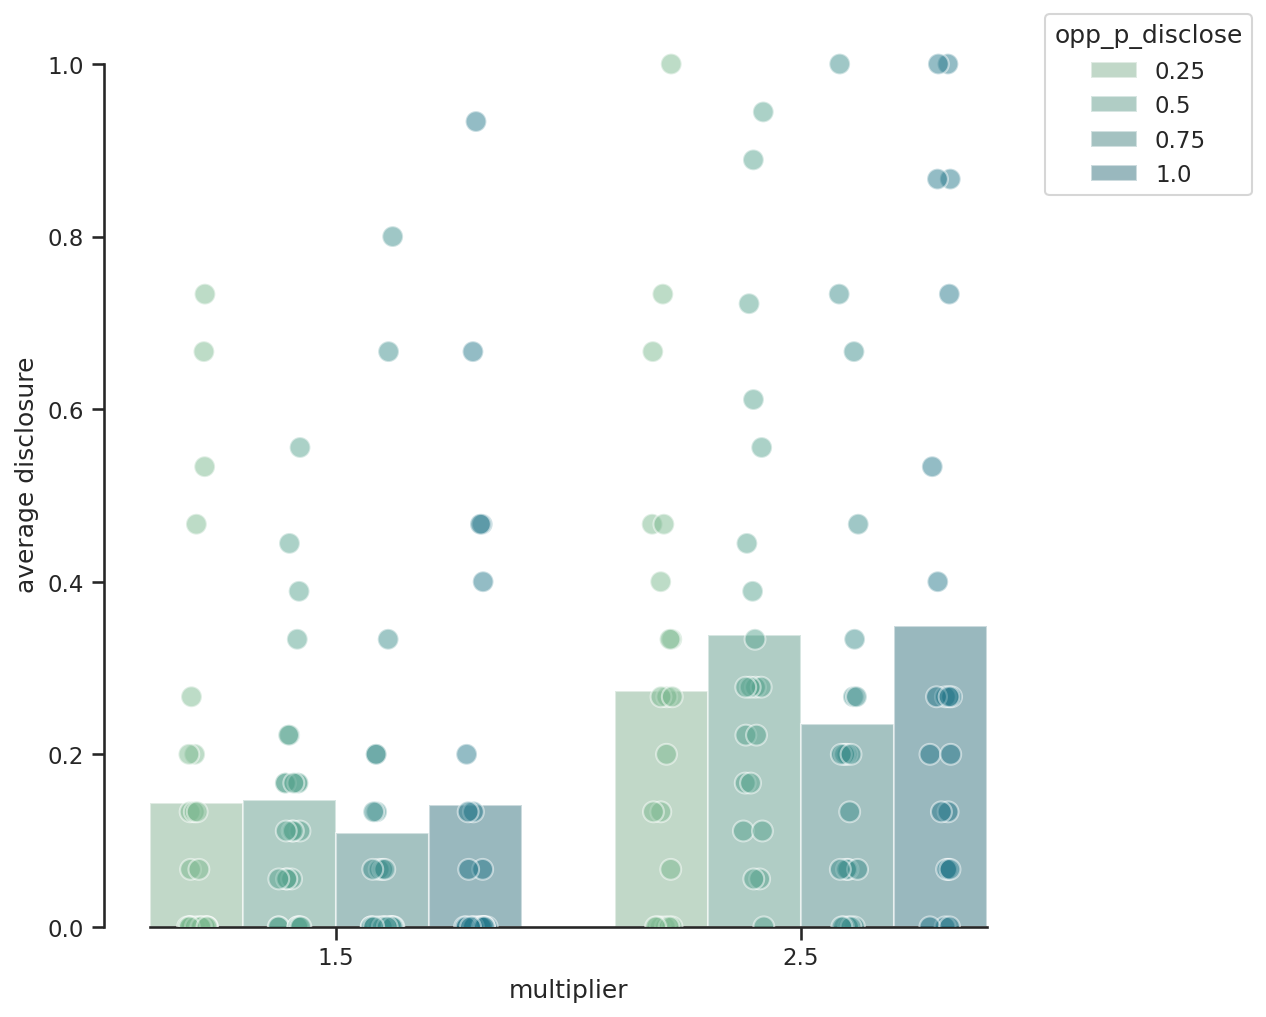

In [56]:
fig, ax = plt.subplots(figsize=(8, 8))
df2 = df.groupby(['prolific_id', 'opp_p_disclose', 'multiplier'], as_index=False)['disclose'].mean()

sns.set_palette("crest")
sns.barplot(x='multiplier', y='disclose', hue='opp_p_disclose', data=df2, ci=None, 
    edgecolor="white",
    # errcolor="black",
    # errwidth=1.5,
    # capsize = 0.05,
    alpha=0.5, ax=ax)
# sns.pointplot(x='multiplier', y='disclose', hue='opp_p_disclose', data=df2, ci=68,')

sns.stripplot(x='multiplier',y='disclose', hue='opp_p_disclose', data=df2, dodge=True, jitter=True, ax=ax, alpha=0.5, size=10, edgecolor='white', linewidth=1)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[4:], labels[4:], title='opp_p_disclose', bbox_to_anchor=(1, 1.02), loc='upper left')
sns.despine(right=True, top=True)

plt.ylabel('average disclosure')

plt.gca().spines['left'].set_smart_bounds(True)
plt.gca().spines['bottom'].set_smart_bounds(True)



<AxesSubplot:xlabel='multiplier', ylabel='disclose'>

<AxesSubplot:xlabel='multiplier', ylabel='disclose'>

<AxesSubplot:xlabel='multiplier', ylabel='disclose'>

Variable:  disclose
               T  dof alternative     p-val          CI95%   cohen-d   BF10  \
T-test -1.081561   54   two-sided  0.284254  [-0.27, 0.08]  0.289059  0.439   

           power  
T-test  0.185962  


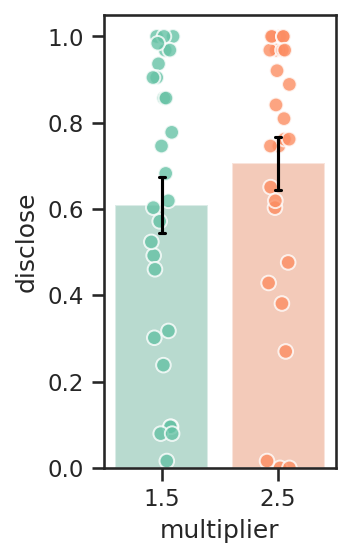

<AxesSubplot:xlabel='multiplier', ylabel='contribution'>

<AxesSubplot:xlabel='multiplier', ylabel='contribution'>

<AxesSubplot:xlabel='multiplier', ylabel='contribution'>

Variable:  contribution
              T  dof alternative    p-val          CI95%   cohen-d   BF10  \
T-test -2.91211   54   two-sided  0.00521  [-0.3, -0.06]  0.778294  8.001   

           power  
T-test  0.815939  


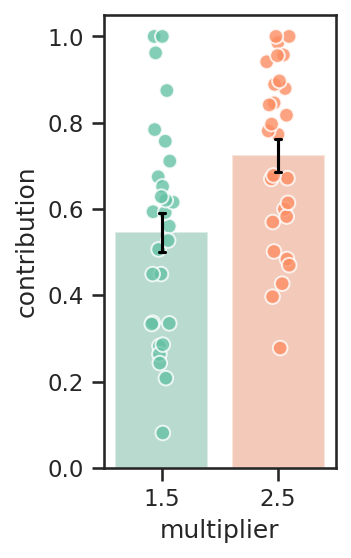

<AxesSubplot:xlabel='multiplier', ylabel='norm_payoff'>

<AxesSubplot:xlabel='multiplier', ylabel='norm_payoff'>

<AxesSubplot:xlabel='multiplier', ylabel='norm_payoff'>

Variable:  norm_payoff
              T  dof alternative         p-val           CI95%   cohen-d  \
T-test -7.31155   54   two-sided  1.285068e-09  [-0.06, -0.04]  1.954094   

             BF10  power  
T-test  6.112e+06    1.0  


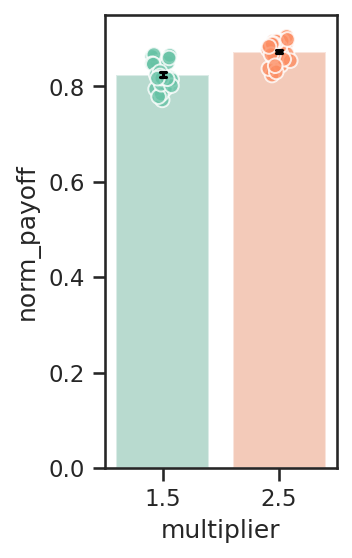

<AxesSubplot:xlabel='multiplier', ylabel='payoff'>

<AxesSubplot:xlabel='multiplier', ylabel='payoff'>

<AxesSubplot:xlabel='multiplier', ylabel='payoff'>

Variable:  payoff
                T  dof alternative         p-val          CI95%   cohen-d  \
T-test -23.073968   54   two-sided  1.222254e-29  [-3.45, -2.9]  6.166777   

             BF10  power  
T-test  1.223e+26    1.0  


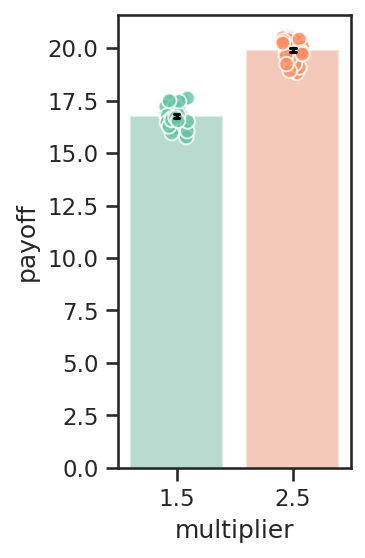

In [57]:
selected_exp = 3
df = dfs[selected_exp].copy()
df['contribution'] /= 10

sns.set_palette("Set2")

for i, vd in enumerate(('disclose', 'contribution', 'norm_payoff', 'payoff')):

    fig, ax = plt.subplots(figsize=(2, 4))
    df2 = df.groupby(['prolific_id',  'multiplier'], as_index=False)[vd].mean()
    # fig.add_subplot(1, 2, [1, 2][i])
    sns.barplot(x='multiplier', y=vd, data=df2, ci=None, 
        edgecolor="white",
        # errcolor="black",
        # errwidth=1.5,
        # erralpha=0,
        # capsize = 0.05,
        alpha=0.5, ax=ax, zorder=0)

    sns.stripplot(
        x='multiplier',
        y=vd,
        data=df2,
        dodge=True,
        jitter=True,
        ax=ax,
        alpha=0.8,
        size=7,
        linewidth=.95,
        edgecolor='white',
        zorder=1)

    sns.pointplot(
        x='multiplier',
        y=vd, data=df2,
        alpha=0,
        ci=68,
        ax=ax,
        color='black',
        scale=0, join=False, errwidth=1.5, errcolor='black', erralpha=0.5, capsize=0.05, zorder=2)

    # plt.ylim(0, 1)
    r = pg.ttest(x=df2[df2['multiplier'] == 1.5][vd],
         y=df2[df2['multiplier'] == 2.5][vd])
    print('Variable: ', vd)
    print(r)
    # break

    plt.show()
# pg.pairwise_ttests(dv='contribution', between='multiplier', within=['opp_multiplier'n ] data=df2, correction='bonf', within_first=True)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[4:], labels[4:], title='opp_p_disclose', bbox_to_anchor=(1, 1.02), loc='upper left')

0.14285714285714285


<AxesSubplot:xlabel='multiplier', ylabel='contribution'>

<AxesSubplot:xlabel='multiplier', ylabel='contribution'>

13.75
25.0
Variable:  contribution
               T        dof alternative     p-val          CI95%   cohen-d  \
T-test -0.420185  42.905377   two-sided  0.676447  [-0.19, 0.12]  0.122673   

         BF10     power  
T-test  0.314  0.069146  


,Source,SS,DF,MS,F,p-unc,np2
0,discloser_type,0.001436,1.0,0.001436,0.022444,0.881629,0.000534
1,multiplier,0.312595,1.0,0.312595,4.884100,0.032609,0.104174
2,discloser_type * multiplier,0.096320,1.0,0.096320,1.504936,0.226746,0.034592
3,Residual,2.688113,42.0,0.064003,NaN,NaN,NaN


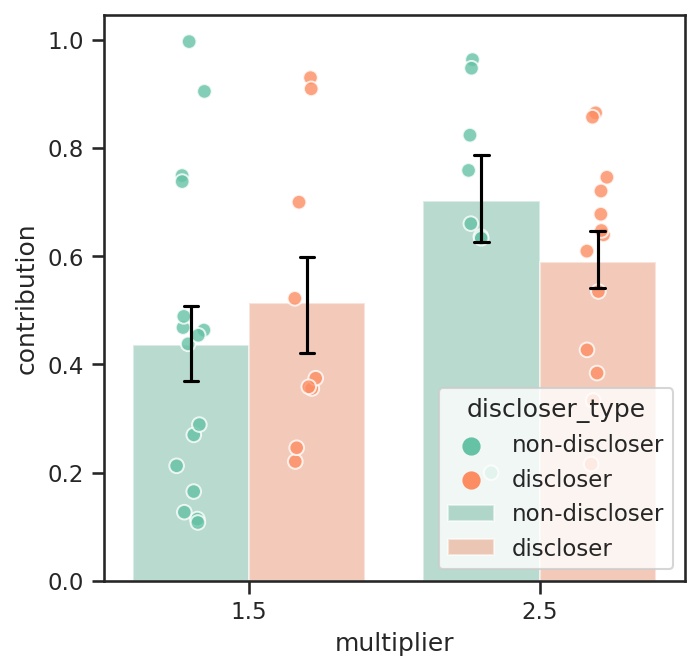

In [102]:
selected_exp = 4
df = dfs[selected_exp].copy()
df['contribution'] /= 10

sns.set({'figure.figsize':(5, 5)})
sns.set_style('ticks')
sns.set_palette("Set2")

vd = 'contribution'
df2 = df.groupby(['prolific_id', 'multiplier'], as_index=False).mean()
med = df2.disclose.median()
print(med)

df2['discloser_type'] = df2['disclose'].apply(lambda x: 'discloser' if x > med else 'non-discloser')

sns.barplot(x='multiplier', y=vd, data=df2, ci=68,
            edgecolor="white",
            hue='discloser_type',
            errcolor="black",
            errwidth=1.5,
            capsize = 0.05,
            alpha=0.5, zorder=0)

sns.stripplot(
    x='multiplier',
    y=vd,
    hue='discloser_type',
    data=df2,
    dodge=True,
    jitter=True,
    alpha=0.8,
    size=7,
    linewidth=.95,
    edgecolor='white',
    zorder=1)
# plt.ylim((0.55, 1))
print(((10 - 5) + 5 * 2.5 + 5 * 2)/2)
print(((10 - 10) + 10 * 2.5 + 10 * 2.5)/2)

# plt.ylim(0.7, .95)
r = pg.ttest(x=df2[df2['discloser_type'] == 'non-discloser'][vd],
            y=df2[df2['discloser_type'] == 'discloser'][vd])
print('Variable: ', vd)
print(r)
# break

pg.anova(data=df2, dv=vd, between=['discloser_type', 'multiplier'])
# pg.pairwise_ttests(dv='contribution', between='multiplier', within=['opp_multiplier'n ] data=df2, correction='bonf', within_first=True)
# handles, labels = ax.get_legend_handles_labels()
#


<AxesSubplot:xlabel='round_number', ylabel='norm_payoff'>

(0.0, 1.0)

Text(0, 0.5, 'avg disclosure')

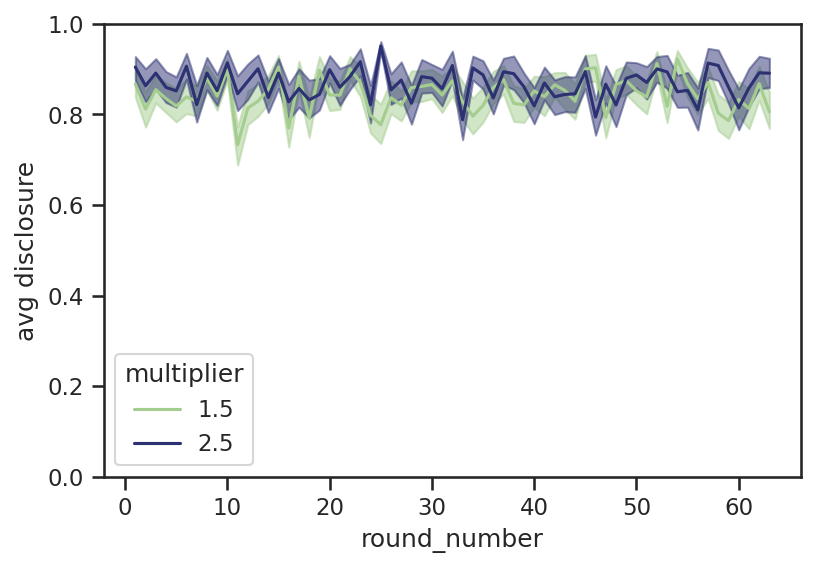

In [59]:
selected_exp = 4
df = dfs[selected_exp].copy()
sns.set_palette("Set2")

# Plot the responses for different events and regions
sns.lineplot(x="round_number", y="norm_payoff",
             hue="multiplier", 
             data=df, palette='crest', ci=68, err_style='band', err_kws={'alpha': 0.5})
plt.ylim([0, 1])
plt.ylabel('avg disclosure')
plt.show()

